In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [2]:
raw_data = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [4]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

## Long term performance with Random Forest Classifier, optimal hyper-parameters

In [6]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [7]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [8]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [9]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [10]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [11]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [12]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [189]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [190]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',400,2400,step=400)
    rf_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)
    preds = rf_clf.predict(val)
    profit = (preds * val_rets).sum()
 
    return profit

In [191]:
optimal_hyperparameters = []

In [192]:
from functools import partial

In [193]:
for i in range(len(start_dates)-1):
    
    study = optuna.create_study(direction="maximize")
    
    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels,
                           val_rets=valid_frames[i]['next_period_return']), n_trials=200,n_jobs=-1)
    
    optimal_hyperparameters.append(study.best_params)  
    print(study.best_params)
    

{'n_estimators': 20, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 5}
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 10}
{'n_estimators': 35, 'max_features': 'sqrt', 'min_samples_leaf': 800, 'max_depth': 15}
{'n_estimators': 15, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 15}
{'n_estimators': 15, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 15}
{'n_estimators': 10, 'max_features': 'log2', 'min_samples_leaf': 1600, 'max_depth': 10}
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 30, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 20, 'max_features': 'log2', 'min_samples_leaf': 1200, 'max_depth': 15}
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 10, 'max_features': 'log2', 'min_samples_leaf': 2400, 'max_depth': 5}
{'n_estimators': 25, 'max_features': 'log2

In [14]:
import pickle

In [15]:
with open(r'optimal_hyperparameters.pkl','rb') as f:
    optimal_hyperparameters = pickle.load(f)

In [194]:
with open(r'optimal_hyperparameters_01.pkl','wb') as f:
    pickle.dump(optimal_hyperparameters,f)

In [16]:
optimal_hyperparameters

[{'n_estimators': 30,
  'max_features': 'log2',
  'min_samples_leaf': 1600,
  'max_depth': 15},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 20},
 {'n_estimators': 10,
  'max_features': 'log2',
  'min_samples_leaf': 800,
  'max_depth': 25},
 {'n_estimators': 30,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 15},
 {'n_estimators': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 15},
 {'n_estimators': 10,
  'max_features': 'log2',
  'min_samples_leaf': 2000,
  'max_depth': 20},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 800,
  'max_depth': 10},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 2400,
  'max_depth': 25},
 {'n_estimators': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 10},
 {'n_estimators': 30,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 25},
 {'n_estimators': 15,
  'max_features': 'log2',

In [17]:
classifiers = []

In [18]:
for hyp_par in optimal_hyperparameters:
    rf_clf = RandomForestClassifier(**hyp_par)
    classifiers.append(rf_clf)

In [19]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(training_data[i],training_labels[i])

In [245]:
with open(r'classifiers.pkl','wb') as f:
    pickle.dump(classifiers,f)

In [246]:
with open(r'classifiers.pkl','rb') as f:
    classifiers = pickle.load(f)

In [21]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [22]:
significant_features = []

In [201]:
for i in range(len(start_dates)-1): 
    fi = randomforest_feat_importances(classifiers[i],training_data[i])
    features = fi[(fi['feat_imp'] > 0.00)]['cols'].values
    significant_features.append(features)

In [24]:
significant_features

[array(['rectq', 'apq', 'equity_invcapq', 'curr_ratioq', 'oeps12',
        'ibcomq', 'oepsxq', 'epsfiq', 'fcf_csfhdq', 'opepsq', 'market_cap',
        'lctq', 'dvpspq', 'pe_op_basicq', 'cash_ratioq', 'debt_atq',
        'cf_yield', 'epsfi12', 'atq', 'oepsxy', 'pe_op_dilq', 'rect_actq',
        'lagbe4', 'ltq', 'yearly_sales', 'dvy', 'csh12q', 'actq', 'revty',
        'prccq', 'invtq', 'quick_ratioq', 'cheq', 'roeq', 'xinty', 'at4',
        'lt_debtq', 'book_value_yield', 'cfo-per-share', 'capxq', 'cshprq',
        'ibcq', 'niq', 'lagseq4', 'dlttq', 'lagppent_alt4', 'mibq',
        'dltisy', 'cfmq', 'txditcq', 'ibcomy'], dtype=object),
 array(['cfmq', 'epspi12', 'oeps12', 'oepf12', 'saleq', 'epsfi12',
        'curr_ratioq', 'pe_op_dilq', 'ptpmq', 'csh12q', 'market_cap',
        'dvpspq', 'cfo-per-share', 'capeiq', 'fcf_yield', 'pe_incq',
        'fcf_csfhdq', 'req', 'rectq', 'yearly_sales', 'oancfy',
        'pay_turnq', 'lagicapt4', 'oancfy_q', 'prccq', 'lagppent_alt4',
        'pretre

In [203]:
with open(r'significant_features_01.pkl','wb') as f:
    pickle.dump(significant_features,f)

In [23]:
with open(r'significant_features.pkl','rb') as f:
    significant_features = pickle.load(f)

In [250]:
new_training_data = []
new_valid_data = []
new_test_data = []

In [251]:
for i in range(len(start_dates)-1): 
    new_training_data.append(training_data[i][significant_features[i]])
    new_valid_data.append(valid_data[i][significant_features[i]])
    new_test_data.append(test_data[i][significant_features[i]])
    

In [206]:
new_valid_data[0].columns

Index(['fcf_yield', 'oepf12', 'yearly_sales', 'opmadq', 'capxq', 'gpmq',
       'prccq', 'ibcomy', 'npmq', 'dlttq',
       ...
       'lagbe4', 'psq', 'mibq', 'sale_invcapq', 'epsx12', 'niq',
       'cash_conversionq', 'opmbdq', 'dpq', 'opcfq'],
      dtype='object', length=105)

In [252]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in new_training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    new_training_data[i] = new_training_data[i].copy()
    new_valid_data[i] = new_valid_data[i].copy()
    new_test_data[i] = new_test_data[i].copy()
    new_training_data[i][float_vars] = scaler.fit_transform(new_training_data[i][float_vars])
    new_valid_data[i][float_vars] = scaler.transform(new_valid_data[i][float_vars])
    new_test_data[i][float_vars] = scaler.transform(new_test_data[i][float_vars])

In [208]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(new_training_data[i],training_labels[i])

In [210]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = rf_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [211]:
import shap

In [212]:
shap_features = []

In [213]:
for i in range(len(start_dates)-1):
    valid_1 = new_valid_data[i].copy()
    cols = new_valid_data[i].columns
    print(len(cols))
    valid_1['rets'] = valid_frames[i]['next_period_return'].values
    rf_clf = classifiers[i]
    explainer = shap.explainers.Permutation(model,valid_1)
    shap_values = explainer(valid_1,max_evals=1000,)
    shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]
    if shap_cols.empty:
        shap_cols = cols
    print(len(shap_cols))
    shap_features.append(shap_cols)
    

105


Permutation explainer: 1123it [06:55,  2.64it/s]                                                                       


59
90


Permutation explainer: 1156it [05:07,  3.60it/s]                                                                       


57
115


Permutation explainer: 1174it [11:37,  1.66it/s]                                                                       


54
113


Permutation explainer: 1137it [08:26,  2.19it/s]                                                                       


85
111


Permutation explainer: 1266it [09:48,  2.12it/s]                                                                       


89
24


Permutation explainer: 1261it [05:56,  3.40it/s]                                                                       


24
95


Permutation explainer: 1256it [06:38,  3.05it/s]                                                                       


63
148


Permutation explainer: 1284it [15:19,  1.38it/s]                                                                       


123
60


Permutation explainer: 1316it [06:15,  3.42it/s]                                                                       


60
107


Permutation explainer: 1414it [06:05,  3.75it/s]                                                                       


76
13


Permutation explainer: 1361it [05:02,  4.39it/s]                                                                       


13
47


Permutation explainer: 1355it [06:35,  3.33it/s]                                                                       


47
60


Permutation explainer: 1475it [07:54,  3.04it/s]                                                                       


34
142


Permutation explainer: 1512it [09:47,  2.53it/s]                                                                       


122
138


Permutation explainer: 1523it [09:44,  2.55it/s]                                                                       


124
110


Permutation explainer: 1499it [07:03,  3.44it/s]                                                                       


84
68


Permutation explainer: 1455it [07:32,  3.14it/s]                                                                       


55
106


Permutation explainer: 1400it [06:08,  3.71it/s]                                                                       


81
164


Permutation explainer: 1376it [13:16,  1.71it/s]                                                                       


153
164


Permutation explainer: 1301it [12:53,  1.66it/s]                                                                       


158
15


Permutation explainer: 1099it [03:43,  4.66it/s]                                                                       


13
80


Permutation explainer: 1029it [08:52,  1.88it/s]                                                                       


52
44


Permutation explainer: 1180it [05:32,  3.46it/s]                                                                       


35
20


Permutation explainer: 1279it [04:14,  4.87it/s]                                                                       


13
63


Permutation explainer: 1353it [07:00,  3.13it/s]                                                                       


39
119


Permutation explainer: 1442it [07:14,  3.23it/s]                                                                       


81
113


Permutation explainer: 1388it [10:26,  2.17it/s]                                                                       


67
42


Permutation explainer: 1443it [05:56,  3.99it/s]                                                                       


42
28


Permutation explainer: 1554it [05:29,  4.58it/s]                                                                       


28
103


Permutation explainer: 1547it [08:31,  2.94it/s]                                                                       


80
133


Permutation explainer: 1612it [09:58,  2.64it/s]                                                                       


109
47


Permutation explainer: 1426it [06:00,  3.82it/s]                                                                       


28
151


Permutation explainer: 1528it [16:51,  1.49it/s]                                                                       


144
116


Permutation explainer: 1610it [08:35,  3.05it/s]                                                                       


91
59


Permutation explainer: 1619it [10:44,  2.47it/s]                                                                       


42
43


Permutation explainer: 1531it [08:35,  2.91it/s]                                                                       


30
85


Permutation explainer: 1625it [15:57,  1.67it/s]                                                                       


58
34


Permutation explainer: 1751it [08:48,  3.25it/s]                                                                       


20
65


Permutation explainer: 1802it [11:01,  2.68it/s]                                                                       


40
74


Permutation explainer: 1875it [14:44,  2.10it/s]                                                                       


44
26


Permutation explainer: 1957it [09:33,  3.32it/s]                                                                       


18
57


Permutation explainer: 1969it [17:11,  1.89it/s]                                                                       


42
163


Permutation explainer: 2061it [1:10:46,  2.07s/it]                                                                     


157
103


Permutation explainer: 1973it [19:57,  1.64it/s]                                                                       


68
43


Permutation explainer: 2042it [12:53,  2.59it/s]                                                                       


32
176


Permutation explainer: 2081it [32:53,  1.05it/s]                                                                       


172
46


Permutation explainer: 2136it [13:53,  2.53it/s]                                                                       


29
28


Permutation explainer: 1949it [11:58,  2.67it/s]                                                                       


15
128


Permutation explainer: 1965it [16:11,  2.00it/s]                                                                       


114
28


Permutation explainer: 1951it [12:41,  2.53it/s]                                                                       


16
28


Permutation explainer: 2006it [13:01,  2.53it/s]                                                                       


24
81


Permutation explainer: 2006it [28:04,  1.18it/s]                                                                       


57
55


Permutation explainer: 2067it [15:14,  2.24it/s]                                                                       


35
74


Permutation explainer: 2109it [23:39,  1.47it/s]                                                                       


56
40


Permutation explainer: 2155it [09:42,  3.64it/s]                                                                       


28
92


Permutation explainer: 2155it [17:07,  2.07it/s]                                                                       

57


In [214]:
with open(r'shap_features_01.pkl','wb') as f:
    pickle.dump(shap_features,f)

In [25]:
with open(r'shap_features.pkl','rb') as f:
    shap_features = pickle.load(f)

In [27]:
shap_features[10]

Index(['beq', 'curr_debtq', 'oancfy_q', 'oancfy', 'intcov_ratioq',
       'debt_invcapq', 'seqq', 'dvpspq', 'epsfxq', 'dvq', 'fcf_csfhdq',
       'book_value_yield', 'efftaxq', 'dpcq', 'actq', 'psq', 'at4', 'oibdpy'],
      dtype='object')

In [256]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [217]:
opt_test_data[1]

,quick_ratioq,fcf_csfhdq,pcfq,xsgay,evmq,fcf_yield,oepf12,cf_yield,dvpspq,oeps12,...,opcfq,capeiq,actq,nopiq,cshoq,epspiq,intcovq,cash_ltq,piq,epsfiq
0,0.943761,-0.217266,0.122199,-0.267934,0.079080,-0.198007,-0.034950,-0.642707,-0.609345,-0.034056,...,-0.251530,0.007903,-0.182217,0.050709,-0.186967,0.024099,0.004608,2.266002,-0.127235,0.021062
1,-0.086185,-0.356346,-0.035955,-0.337319,-1.008394,-0.406912,-0.148162,2.737811,-0.416958,-0.151559,...,0.419426,0.008470,1.396938,0.955536,0.368063,-0.397836,0.005611,-0.323813,-0.490005,-0.398602
2,-0.317386,-0.111938,-0.011194,0.345250,0.015285,-0.016963,-0.008932,-0.108673,-0.200524,-0.011540,...,-0.179077,0.017206,-0.159999,0.027119,-0.212314,-0.040432,0.004608,-0.118076,-0.134250,-0.034556
3,-0.232305,0.049499,0.007315,-0.198088,0.013118,0.051241,0.069825,-0.203505,-0.609345,0.077115,...,-0.200667,0.027228,0.044884,0.027669,-0.286651,0.197838,0.009246,-0.356163,-0.046697,0.187917
4,-0.164772,0.098515,-0.033265,3.390534,0.019836,0.009106,0.048026,-0.334669,0.496878,0.048971,...,1.090416,0.019878,1.279020,0.472100,1.685134,0.237549,0.042413,-0.244303,2.158498,0.238479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,-0.240716,-0.144245,-0.025578,0.083521,-0.004318,-0.058058,-0.015964,-0.278956,0.641168,-0.019983,...,-0.031139,0.017299,0.696185,0.062553,0.221718,0.068775,0.009303,-0.325713,0.211921,0.071624
1132,-0.246900,0.077786,0.162820,-0.263041,0.016386,-0.032305,0.032556,-0.387362,-0.416958,0.034899,...,-0.263126,0.016968,-0.378984,0.023169,-0.372983,0.138270,0.004608,-0.272076,-0.173443,0.137355
1133,0.176708,-0.307842,-0.033820,-0.211596,0.004571,-0.232850,-0.084172,0.400038,-0.609345,-0.084716,...,0.071823,0.007877,0.125469,0.039205,0.343712,-0.045396,0.018186,0.032240,0.016430,-0.044668
1134,0.439776,0.014379,0.356613,-0.308801,0.017270,-0.028351,0.009351,-0.453907,-0.609345,0.013790,...,-0.281381,0.014460,-0.395252,0.028248,-0.391962,0.168054,0.004608,0.356833,-0.192321,0.152523


In [257]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

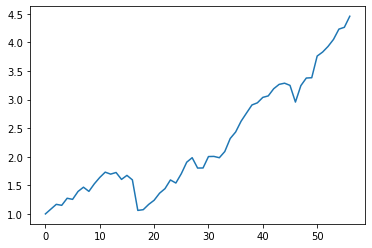

In [258]:
plt.plot(x);

In [259]:
len(x)

57

In [261]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

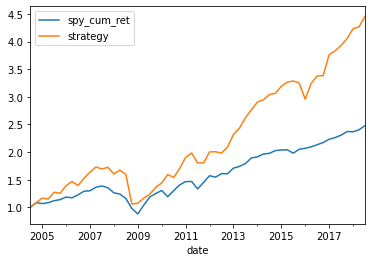

In [262]:
SPY.plot();

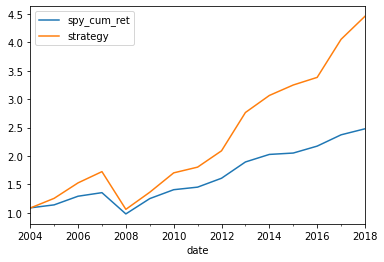

In [263]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [264]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7687828128384174


In [265]:
x[-1]

4.456992195589677

In [266]:
SPY['spy_cum_ret'][-1]

2.4779340000000003

In [227]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [267]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

In [268]:
beta 

1.5246470397535217

In [269]:
IR = np.mean(residual_ret)/np.std(residual_ret)

In [270]:
IR

0.3399250879172628

In [271]:
alpha = np.mean(residual_ret)

In [272]:
alpha

0.03896201899990842